In [6]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as ps
import joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import tpot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

In [7]:
df = pd.read_csv('Titanic_Dataset.csv')

In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df.rename(columns={'Pclass':'Passenger_Class'},inplace=True)
df.rename(columns={'SibSp':'total_siblings_and_spouses_aboard'},inplace=True)
df.rename(columns={'Parch':'total_parents_and_children_aboard'},inplace=True)
df.head()

,PassengerId,Survived,Passenger_Class,Name,Sex,Age,total_siblings_and_spouses_aboard,total_parents_and_children_aboard,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# Define the extract_title function
def extract_title(name):
    titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.', 'Rev.']
    for title in titles:
        if title in name:
            return title
    return 'Other'

# Create a new 'Title' column
df['Title'] = df['Name'].apply(lambda x: extract_title(x))

In [11]:
columns_to_drop = ['Ticket', 'Cabin','Name', 'PassengerId']
existing_columns = [col for col in columns_to_drop if col in df.columns]
if existing_columns:
    df.drop(existing_columns, axis=1, inplace=True)
df.head()

,Survived,Passenger_Class,Sex,Age,total_siblings_and_spouses_aboard,total_parents_and_children_aboard,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr.
1,1,1,female,38.0,1,0,71.2833,C,Mrs.
2,1,3,female,26.0,0,0,7.9250,S,Miss.
3,1,1,female,35.0,1,0,53.1000,S,Mrs.
4,0,3,male,35.0,0,0,8.0500,S,Mr.


In [12]:
def preprocess_data(data):
    
    # Handle missing values
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

    # Convert categorical variables to numerical
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
    data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    data['Title'] = data['Title'].map({'Mr.': 0, 'Mrs.': 1, 'Miss.': 2, 'Master.': 3, 'Dr.': 4, 'Rev.': 5, 'Other': 6})

    # Convert 'Age' to integers
    data['Age'] = data['Age'].astype(int)
    
    return data

df = preprocess_data(df)
df.head()

,Survived,Passenger_Class,Sex,Age,total_siblings_and_spouses_aboard,total_parents_and_children_aboard,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,0,0
1,1,1,1,38,1,0,71.2833,1,1
2,1,3,1,26,0,0,7.9250,0,2
3,1,1,1,35,1,0,53.1000,0,1
4,0,3,0,35,0,0,8.0500,0,0


In [13]:
print(f'Data Frame Shape (rows, columns): {df.shape}')

Data Frame Shape (rows, columns): (891, 9)


In [14]:
df.describe()

,Survived,Passenger_Class,Sex,Age,total_siblings_and_spouses_aboard,total_parents_and_children_aboard,Fare,Embarked,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.345679,0.523008,0.381594,32.204208,0.361392,0.842873
std,0.486592,0.836071,0.477990,13.028212,1.102743,0.806057,49.693429,0.635673,1.229781
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,6.000000


In [15]:
len(df.Survived.unique())

2

In [16]:
Sum = df.isnull().sum()
Percentage = ( df.isnull().sum()/df.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
Survived,0,0.0
Passenger_Class,0,0.0
Sex,0,0.0
Age,0,0.0
total_siblings_and_spouses_aboard,0,0.0
total_parents_and_children_aboard,0,0.0
Fare,0,0.0
Embarked,0,0.0
Title,0,0.0


In [17]:
df.head()

,Survived,Passenger_Class,Sex,Age,total_siblings_and_spouses_aboard,total_parents_and_children_aboard,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,0,0
1,1,1,1,38,1,0,71.2833,1,1
2,1,3,1,26,0,0,7.9250,0,2
3,1,1,1,35,1,0,53.1000,0,1
4,0,3,0,35,0,0,8.0500,0,0


In [18]:
Sum = df.isnull().sum()
Percentage = ( df.isnull().sum()/df.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
Survived,0,0.0
Passenger_Class,0,0.0
Sex,0,0.0
Age,0,0.0
total_siblings_and_spouses_aboard,0,0.0
total_parents_and_children_aboard,0,0.0
Fare,0,0.0
Embarked,0,0.0
Title,0,0.0


<Figure size 1200x1000 with 0 Axes>

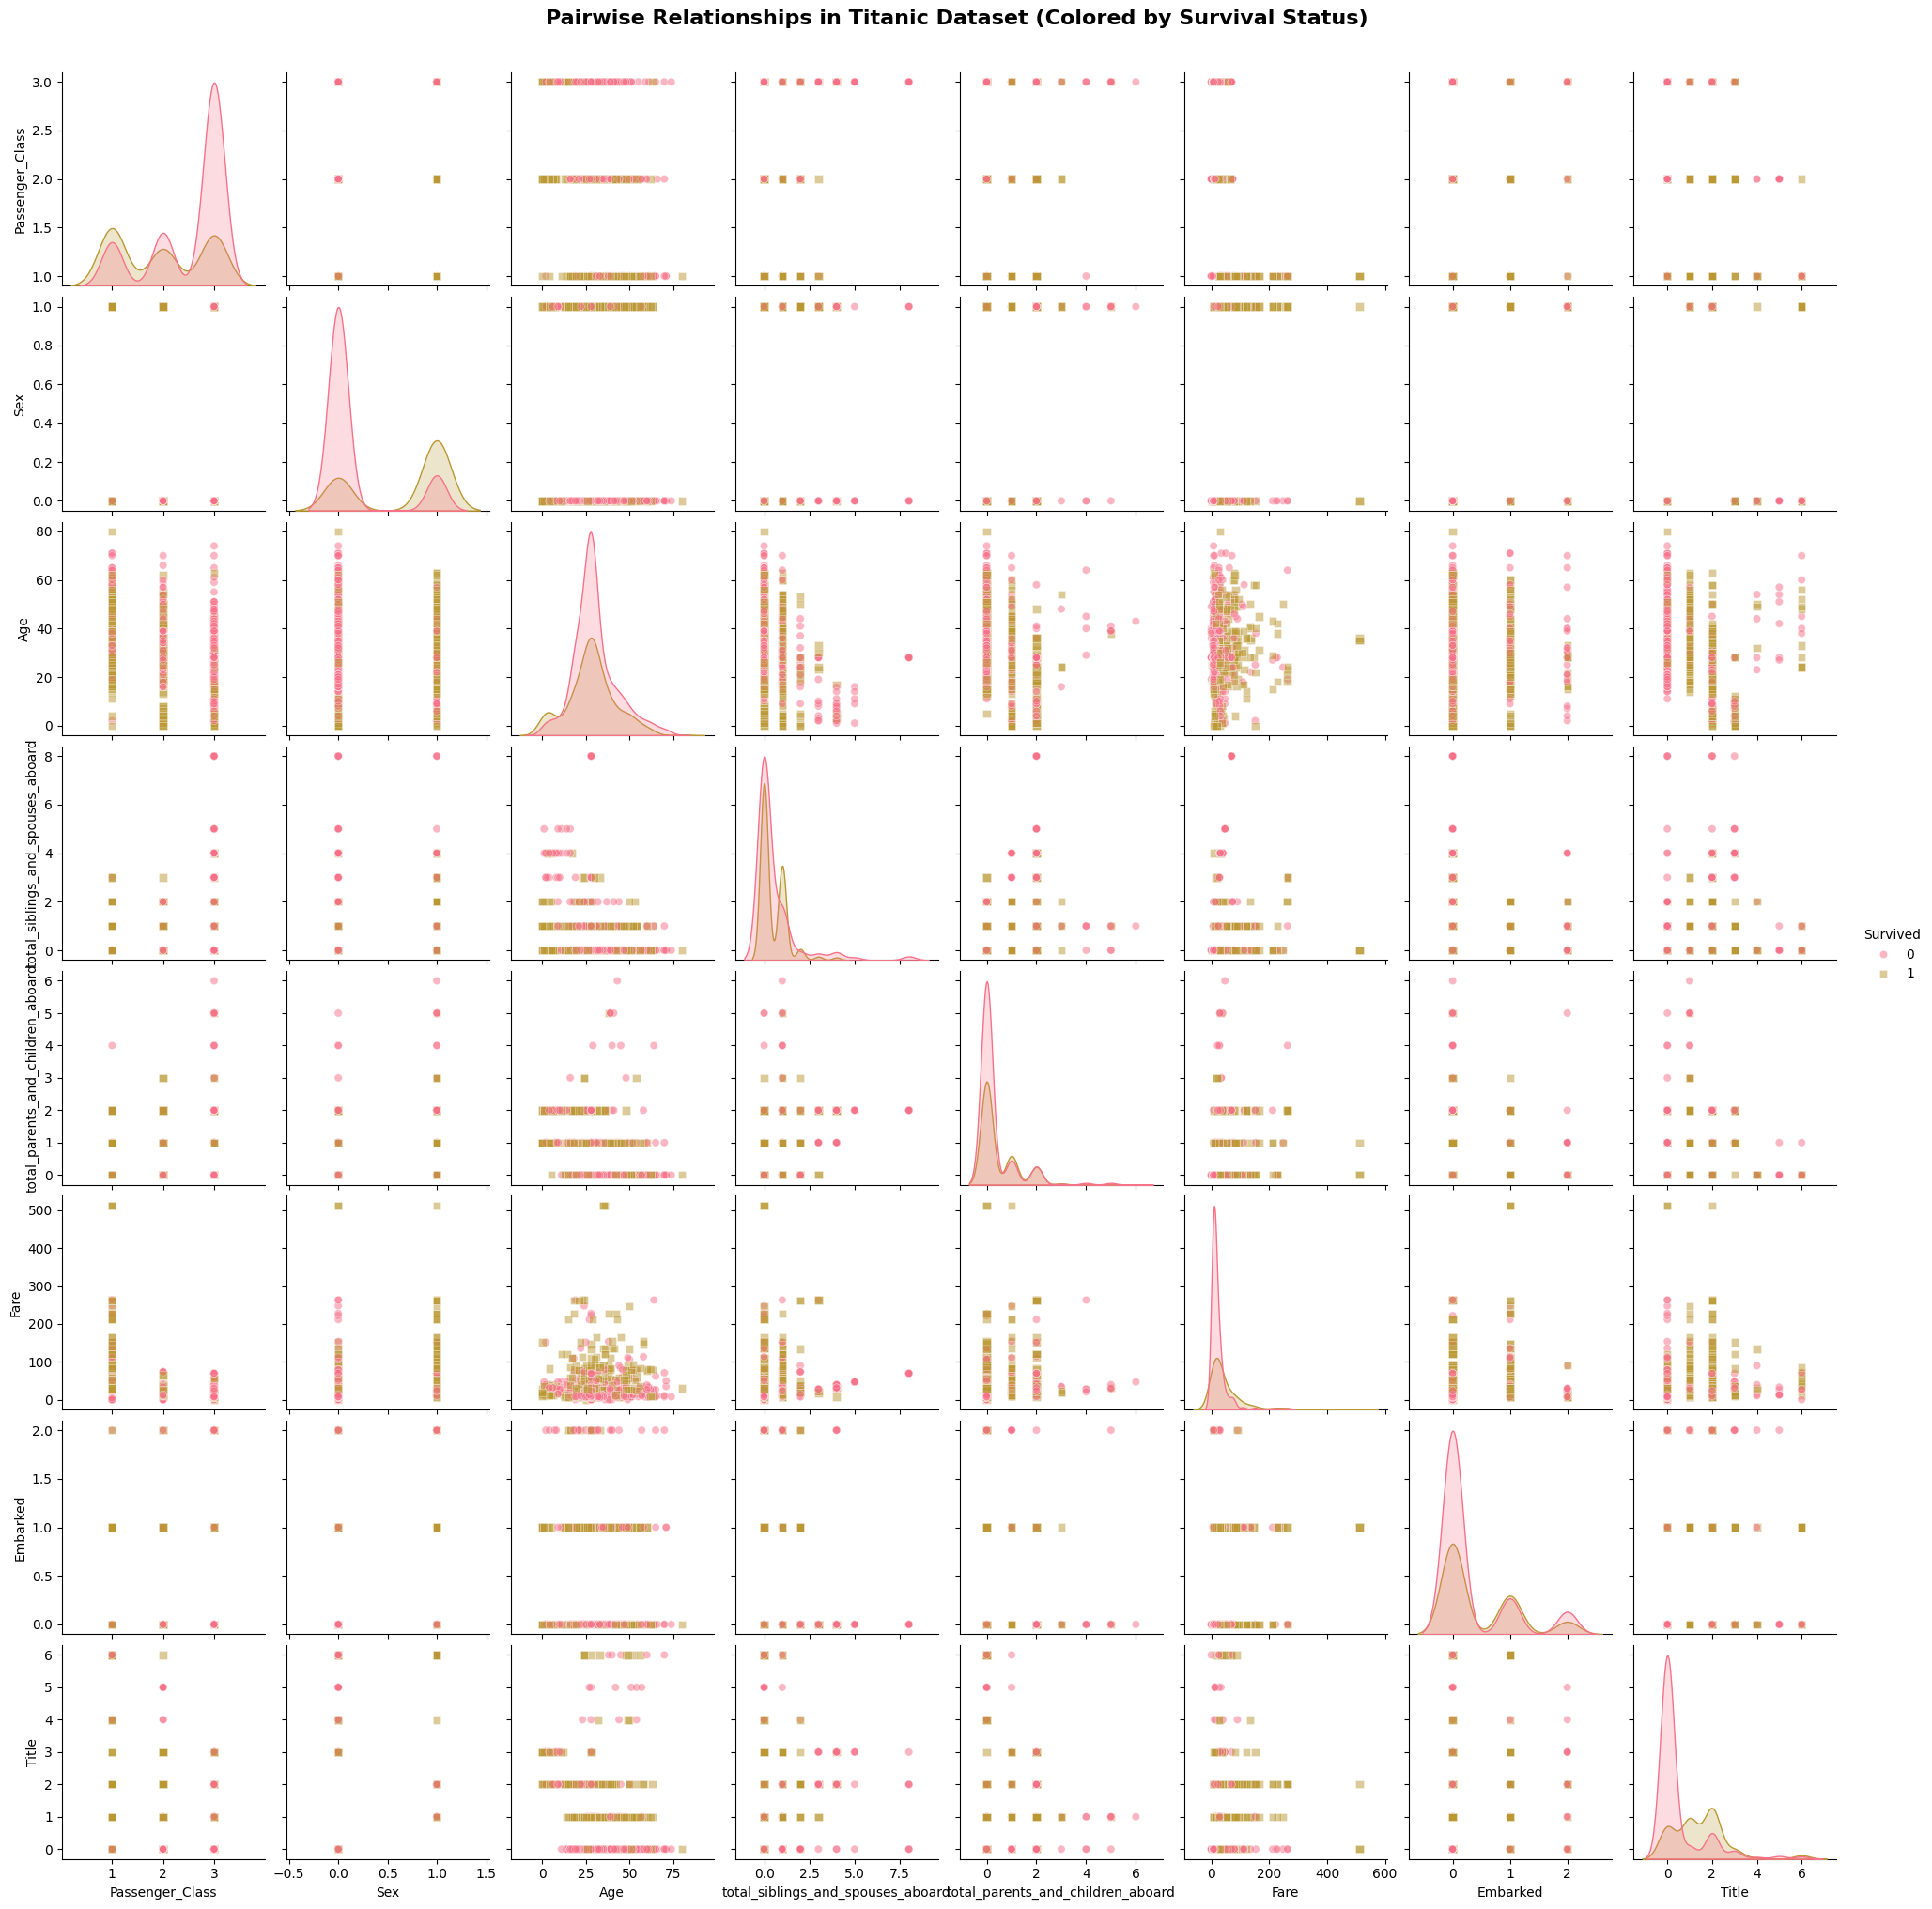

In [19]:
# Set a custom color palette
custom_palette = sns.color_palette("husl")

# Increase figure size
plt.figure(figsize=(12, 10))

# Use pairplot with custom palette and markers
sns.pairplot(df, hue="Survived", palette=custom_palette, markers=["o", "s"], plot_kws={'alpha': 0.5})

# Customize title
plt.suptitle("Pairwise Relationships in Titanic Dataset (Colored by Survival Status)", y=1.02, fontsize=16, fontweight='bold')

# Display the plot
plt.show()


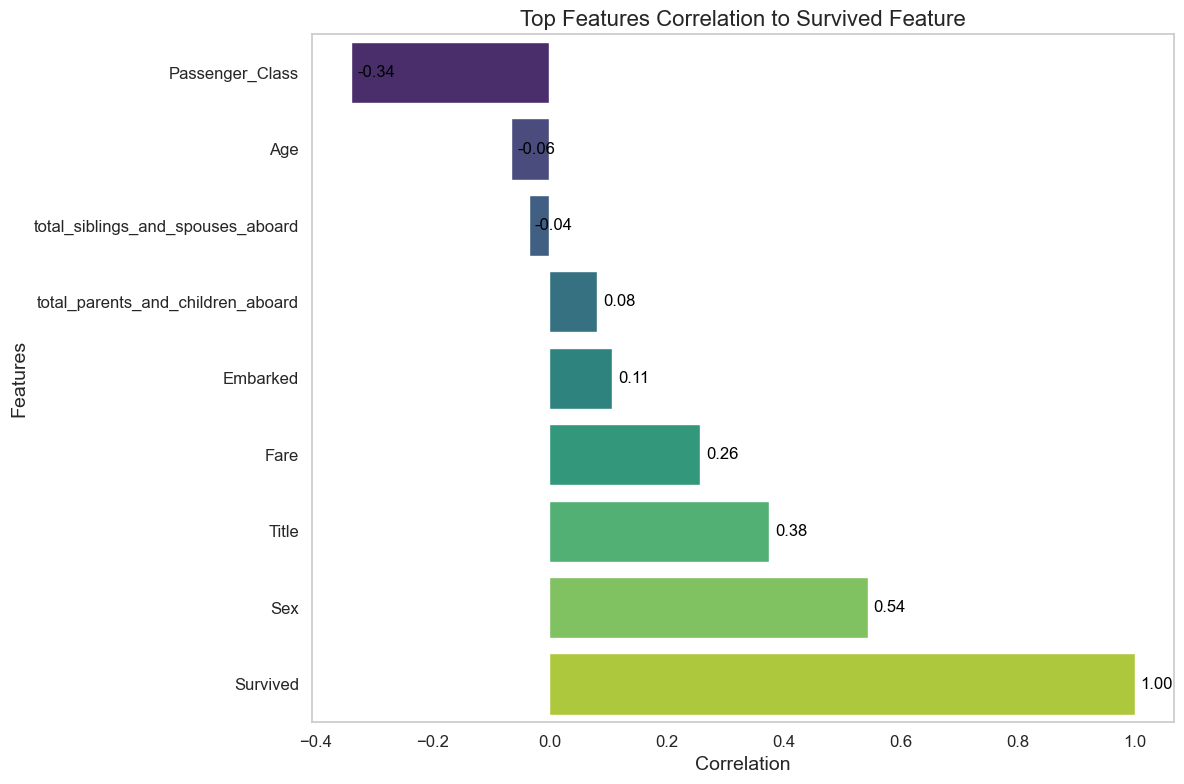

In [20]:
# Use Seaborn for enhanced styling
sns.set(style="whitegrid")

# Choose a color palette with better contrast
colors = sns.color_palette("viridis", len(df.columns))

# Sort features by correlation to improve readability
sorted_features = df.corr()['Survived'].sort_values()

# Display only the top N features with the highest correlation
top_n = 10
top_features = sorted_features[-top_n:]

plt.figure(figsize=(12, 8))

# Use Seaborn barplot for simplicity
ax = sns.barplot(x=top_features.values, y=top_features.index, palette=colors, ci=None, errwidth=0)

# Display correlation values on the bars with larger font size
for i, v in enumerate(top_features.values):
    ax.text(v + 0.01, i, f'{v:.2f}', va='center', color='black', fontsize=12)

ax.set_title('Top Features Correlation to Survived Feature', fontsize=16)
ax.set_xlabel('Correlation', fontsize=14)
ax.set_ylabel('Features', fontsize=14)

# Increase font size for ticks
ax.tick_params(axis='both', which='major', labelsize=12)

# Remove redundant information
ax.grid(False)

plt.tight_layout()
plt.show()

In [21]:
# df = df.astype({
#     'Survived': int,
#     'Passenger_Class': int,
#     'Sex': int,
#     'Age': int,
#     'total_siblings_and_spouses_aboard': int,
#     'total_parents_and_children_aboard': int,
#     'Fare': float,
#     'Embarked': int,
#     'Title': int
# }).round({'Fare': 2})

In [22]:
df.head()

,Survived,Passenger_Class,Sex,Age,total_siblings_and_spouses_aboard,total_parents_and_children_aboard,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,0,0
1,1,1,1,38,1,0,71.2833,1,1
2,1,3,1,26,0,0,7.9250,0,2
3,1,1,1,35,1,0,53.1000,0,1
4,0,3,0,35,0,0,8.0500,0,0


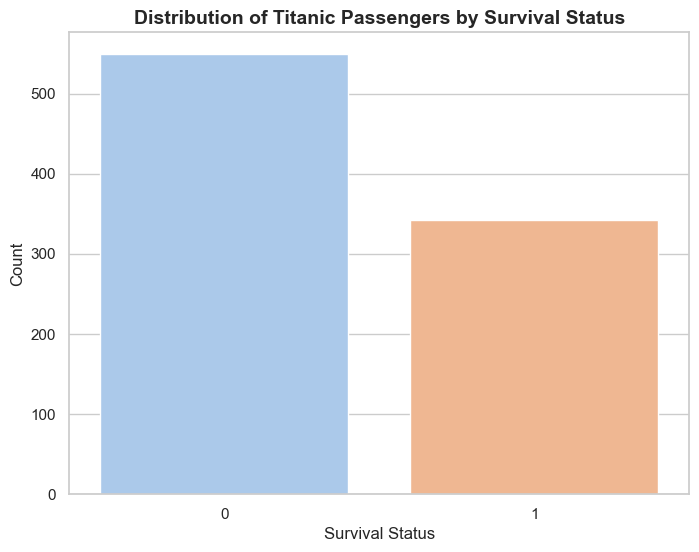

In [23]:
# Set a custom color palette
custom_palette = sns.color_palette("pastel")

# Increase figure size
plt.figure(figsize=(8, 6))

# Use countplot with custom palette
sns.countplot(data=df, x="Survived", palette=custom_palette)

# Add descriptive axis labels
plt.xlabel("Survival Status", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Customize title
plt.title("Distribution of Titanic Passengers by Survival Status", fontsize=14, fontweight='bold')

# Display the plot
plt.show()

In [24]:
X = df.drop(columns=['Survived'],axis=1) 
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

In [25]:
lr = LogisticRegression(random_state=40)
lr.fit(X_train, y_train)

LogisticRegression(random_state=40)

In [26]:
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)
print('Accuracy in Train set   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  set   : {:.2f}'.format(test_accuracy), sep='\n')

Accuracy in Train set   : 0.80
Accuracy in Test  set   : 0.83


In [ ]:
df_bins3= df.copy()

In [ ]:
bins = [0, 18, 30, 50, 100]  # Define your age bins
labels = ['0-18', '19-30', '31-50', '51+']  # Label the bins

df_bins3['Age_Group'] = pd.cut(df_bins3['Age'], bins=bins, labels=labels)

#df_bins3.type = df_bins3.type.map({'white':0, 'red':1})

print(df_bins3[['Age_Group','Age']].head(5))

In [ ]:
df_bins3 = df_bins3.drop(columns=['Age'],axis=1).copy()

In [ ]:
X = df_bins3.drop(columns=['Age_Group'],axis=1) 
y = df_bins3.Age_Group

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

In [ ]:
X.columns

In [ ]:
lr    = LogisticRegression(random_state=40)
lr.fit(X_train, y_train)

In [ ]:
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy Score of Train Model : {:.2f}'.format(train_accuracy), 
      'Accuracy Score of Test  Model : {:.2f}'.format(test_accuracy), sep='\n')

In [27]:
AutoML = tpot.TPOTClassifier(
                            generations=5,
                            population_size=100,
                            offspring_size=None,
                            mutation_rate=0.9,
                            crossover_rate=0.1,
                            scoring=None,
                            cv=5,
                            subsample=1.0,
                            n_jobs=1,
                            max_time_mins=None,
                            max_eval_time_mins=5,
                            random_state=None,
                            config_dict=None,
                            template=None,
                            warm_start=False,
                            memory=None,
                            use_dask=False,
                            periodic_checkpoint_folder=None,
                            early_stop=None,
                            verbosity=2,
                            disable_update_check=False,
                            )

In [28]:
AutoML.fit(X_train,y_train)

Optimization Progress:   0%|          | 0/600 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.837082635674185

Generation 2 - Current best internal CV score: 0.8384615384615385

Generation 3 - Current best internal CV score: 0.8384713877671623

Generation 4 - Current best internal CV score: 0.8398699891657639

Generation 5 - Current best internal CV score: 0.8455037919826653

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.55, min_samples_leaf=3, min_samples_split=2, n_estimators=100)


TPOTClassifier(generations=5, verbosity=2)

In [29]:
#save model 
with open('model-v1.joblib', 'wb') as f:
    joblib.dump(lr,f)


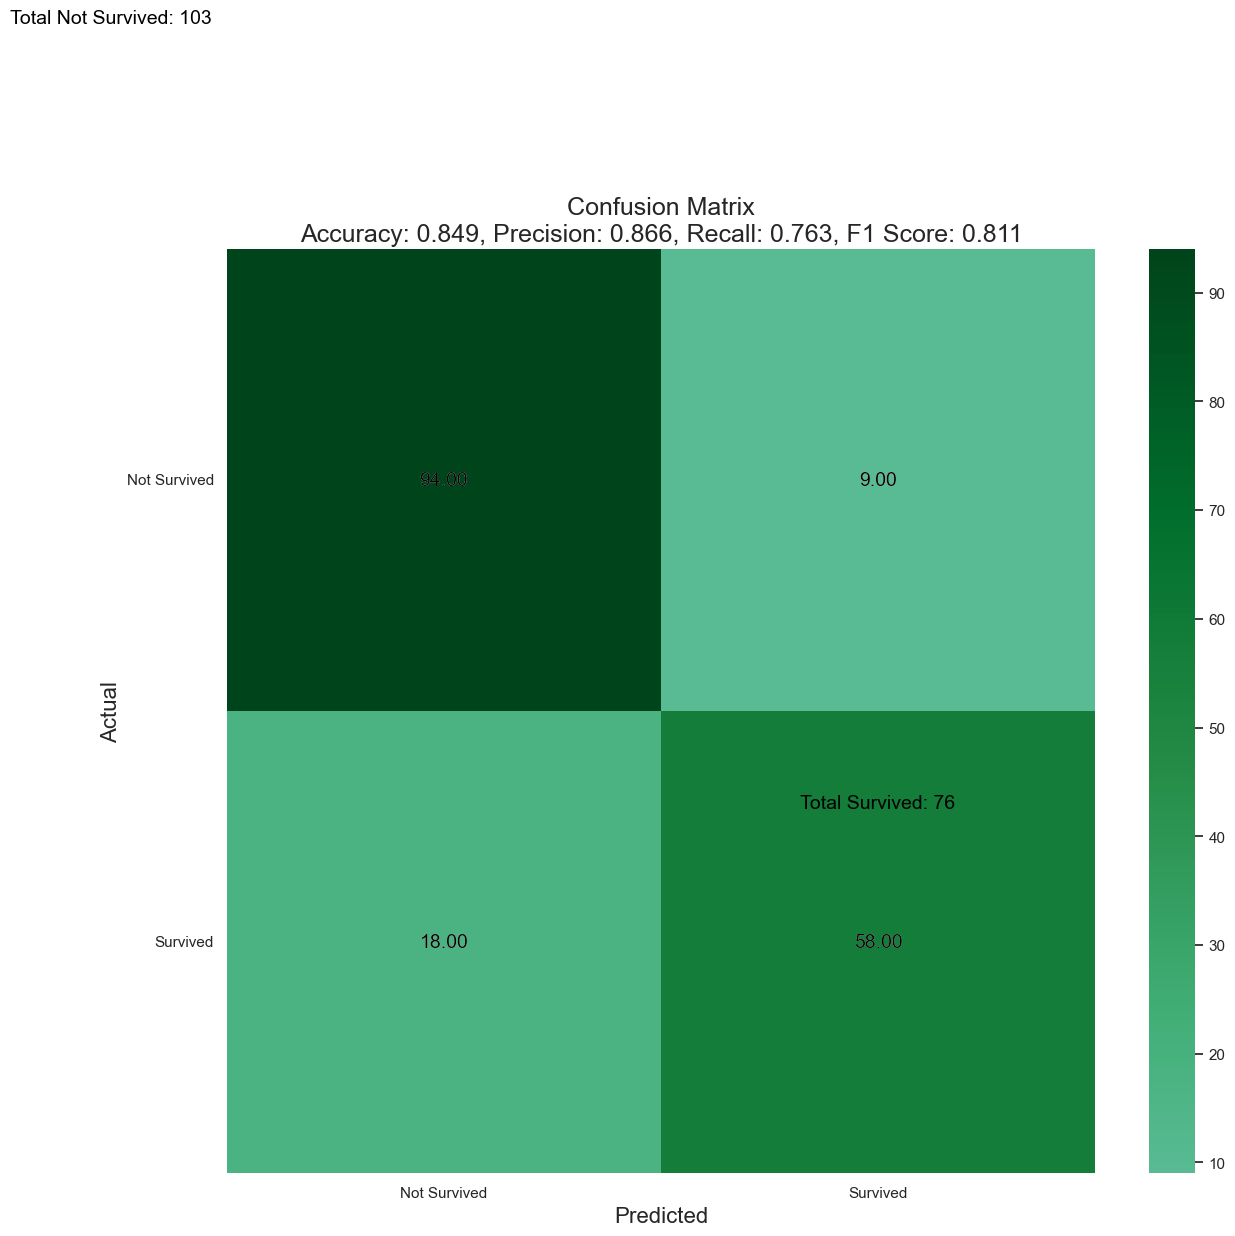

In [30]:
# Get predictions
predictions = AutoML.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, predictions)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predictions, average='binary')
cm_matrix = confusion_matrix(y_test, predictions, labels=[0, 1])

# Set up the figure
plt.figure(figsize=(14, 12))

# Use a different color map ('BuGn' or 'viridis')
sns.heatmap(cm_matrix, annot=True, fmt=".2f", cmap='BuGn', cbar=True, center=0.5, annot_kws={"size": 14})

# Add class labels and total counts
class_labels = ['Not Survived', 'Survived']
class_counts = [f'Total {label}: {count}' for label, count in zip(class_labels, np.bincount(y_test))]
plt.xticks(ticks=[0.5, 1.5], labels=class_labels, rotation=0)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels, rotation=0)
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}', size=18)

# Display total counts
plt.text(-0.5, -0.5, class_counts[0], ha='left', va='center', fontsize=14, color='black')
plt.text(1.5, 1.2, class_counts[1], ha='center', va='center', fontsize=14, color='black')

plt.xlabel("Predicted", fontsize=16)
plt.ylabel("Actual", fontsize=16)

# Add annotations for actual and predicted labels
for i in range(2):
    for j in range(2):
        plt.text(j + 0.5, i + 0.5, f"{cm_matrix[i, j]:.2f}", ha='center', va='center', fontsize=14, color='black')

plt.show()


In [31]:
AutoML.export('pipeline.py')